### Imports and Loading

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
from sklearn.model_selection import cross_val_predict, train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, silhouette_score

from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
from sklearn.preprocessing import scale, StandardScaler

In [114]:
#Import data
kilothonGames = pd.read_csv('KilothonGames.csv')
concepts = pd.read_csv('concepts.csv')
gamerules = pd.read_csv('gamerulesets.csv')
games = pd.read_csv('games.csv')
rulesetconcept = pd.read_csv('rulesetconcepts.csv')
rsc_uct = pd.read_csv('rulesetconceptsuct.csv')
rsc_ab = pd.read_csv('rulesetconceptsab.csv')

### Get infos of the different database

In [115]:
#Shapes

print(concepts.shape)
print(gamerules.shape)
print(games.shape)
print(rulesetconcept.shape)
print(rsc_uct.shape)
print(rsc_ab.shape)

(779, 9)
(1854, 20)
(1458, 26)
(1106316, 5)
(1164417, 5)
(1164417, 5)


In [116]:
# Column names for each df
print(concepts.columns)
print(gamerules.columns)
print(games.columns)
print(rulesetconcept.columns)
print(rsc_uct.columns)
print(rsc_ab.columns)

Index(['Unnamed: 0', 'Id', 'Name', 'Description', 'TypeId', 'DataTypeId',
       'ComputationTypeId', 'TaxonomyString', 'LeafNode'],
      dtype='object')
Index(['Unnamed: 0', 'Id', 'GameId', 'Name', 'NativeName', 'Summary', 'Type',
       'Description', 'Rules', 'Reference', 'Origin', 'Author', 'Publisher',
       'Date', 'OriginPoint', 'EvidenceRange', 'SelfContained', 'Notes',
       'DisableWebApp', 'WishlistRuleset'],
      dtype='object')
Index(['Unnamed: 0', 'Id', 'Name', 'NativeName', 'Description', 'MainRuleset',
       'LudiiRuleset', 'Reference', 'Origin', 'DLPGame', 'PublicGame',
       'knownAliases', 'Author', 'Publisher', 'ProprietaryGame', 'Credit',
       'SeeAlso', 'BGGId', 'OriginPoint', 'EvidenceRange', 'WishlistGame',
       'Notes', 'HelpUs', 'ForceRulesetInLud', 'DisableWebApp',
       'ReconstructionDescriptionDone'],
      dtype='object')
Index(['Unnamed: 0', 'Id', 'RulesetId', 'ConceptId', 'Value'], dtype='object')
Index(['Unnamed: 0', 'Id', 'RulesetId', 'Conc

As discussed, we will only keep the following columns for our final datframe:

- Concepts: ID, LeafNode
- Gamerules: ID, GameID, Name, Type
- Games: ID, Name, MainRuleSet, LudiiRuleset
- Rulesetconcept: ID, RuleSetId, ConceptID, value 

In [117]:
concepts = concepts[~concepts['TaxonomyString'].str.startswith('6')]
concepts = concepts[~concepts['TaxonomyString'].str.startswith('1')]
concepts = concepts[~concepts['TaxonomyString'].str.startswith('4')]
concepts = concepts[~concepts['TaxonomyString'].str.startswith('5')]
concepts = concepts[~concepts['TaxonomyString'].str.startswith('7')]
concepts = concepts[~concepts['TaxonomyString'].str.startswith('3.1')]
concepts = concepts[~concepts['TaxonomyString'].str.startswith('3.2')]


concepts = concepts[concepts['LeafNode']!=0]

In [118]:
concepts

,Unnamed: 0,Id,Name,Description,TypeId,DataTypeId,ComputationTypeId,TaxonomyString,LeafNode
34,34,35,SquareShape,Square shape.,11,1,1,2.1.1.1.1,1
35,35,36,HexShape,Hexagonal shape.,11,1,1,2.1.1.1.2,1
36,36,37,TriangleShape,Triangle shape.,11,1,1,2.1.1.1.3,1
37,37,38,DiamondShape,Diamond shape.,11,1,1,2.1.1.1.4,1
38,38,39,RectangleShape,Rectangle shape.,11,1,1,2.1.1.1.5,1
...,...,...,...,...,...,...,...,...,...
515,515,516,NoProgressWinFrequency,Frequency of No Progress Win.,5,4,2,3.4.6.2.1,1
517,517,518,NoProgressLossFrequency,Frequency of No Progress Loss.,5,4,2,3.4.6.3.1,1
519,519,520,NoProgressDrawFrequency,Frequency of No Progress Draw.,5,4,2,3.4.6.4.1,1
521,521,522,DrawFrequency,Frequency of Draw.,5,4,2,3.4.7.1,1


In [119]:
concepts = concepts.drop([ 'Unnamed: 0', 'Description', 'TypeId', 'DataTypeId', 'ComputationTypeId', 'TaxonomyString'], axis = 1);
gamerules = gamerules.drop(['Unnamed: 0', 'NativeName', 'Summary', 'Description', 'Rules', 'Reference', 'Origin', 'Author', 'Publisher', 'Date', 'OriginPoint', 'EvidenceRange', 'SelfContained', 'Notes', 'DisableWebApp', 'WishlistRuleset', 'Type'], axis = 1);
games = games.drop(['Unnamed: 0','NativeName', 'Description', 'Reference', 'Origin', 'DLPGame', 'PublicGame', 'knownAliases', 'Author', 'Publisher', 'ProprietaryGame', 'Credit', 'SeeAlso', 'BGGId', 'OriginPoint', 'EvidenceRange', 'WishlistGame', 'Notes', 'HelpUs', 'ForceRulesetInLud', 'DisableWebApp', 'ReconstructionDescriptionDone'], axis = 1);
rulesetconcept = rulesetconcept.drop(['Unnamed: 0'], axis = 1)
rsc_uct = rsc_uct.drop(['Unnamed: 0'], axis = 1)
rsc_ab = rsc_ab.drop(['Unnamed: 0'], axis = 1)
concepts

,Id,Name,LeafNode
34,35,SquareShape,1
35,36,HexShape,1
36,37,TriangleShape,1
37,38,DiamondShape,1
38,39,RectangleShape,1
...,...,...,...
515,516,NoProgressWinFrequency,1
517,518,NoProgressLossFrequency,1
519,520,NoProgressDrawFrequency,1
521,522,DrawFrequency,1


Now that the df are filtered with the only attributes that we need, we will merge them in a final dataframe.

We will join using the following idea: 

Join Game Ruleset and Games on GameId and Id  --> Merge_One

Join Game Ruleset and Ruleset Concepts on Id and RulesetId --> Merge_two		

Join Concepts and Ruleset Concepts on Id and ConceptId --> Merge_three

In [120]:
def merge(one, two, on, left, right):
  new = pd.merge(one, two, on = on, left_on = left, right_on = right)

  return new

In [121]:
merge_one = merge(games, gamerules, None, 'Id', 'GameId')
merge_two = merge(rulesetconcept, gamerules, None, 'RulesetId', 'Id')
merge_three = merge(concepts, rulesetconcept, None, 'Id', 'ConceptId')

merge_three.drop(['Id_y'], axis=1, inplace=True)
merge_three = merge_three[merge_three['LeafNode']!=0]

Create a dataframe by merging the first three created above

In [122]:
df = merge(merge_one, merge_two, 'GameId', None, None)
df = df.drop([ 'Id_y_y', 'Id_x_x', 'Value', 'Id_x_y', 'ConceptId', 'Name_y', 'Id_y_x'], axis = 1);
df.head()

,Name_x,MainRuleset,LudiiRuleset,GameId,RulesetId,Name
0,Senet,528,529.0,3,529,Bell
1,Senet,528,529.0,3,529,Bell
2,Senet,528,529.0,3,529,Bell
3,Senet,528,529.0,3,529,Bell
4,Senet,528,529.0,3,529,Bell


Do the same merging as merge 3 but for the datasets of UCT and AB

In [123]:
merge_three_uct = pd.merge(concepts, rsc_uct, left_on='Id', right_on='ConceptId')

merge_three_uct.drop(['Id_y'], axis=1, inplace=True)
merge_three_uct = merge_three_uct[merge_three_uct['LeafNode']!=0]
merge_three_uct.head()

,Id_x,Name,LeafNode,RulesetId,ConceptId,Value
0,35,SquareShape,1,1656,35,0.0
1,35,SquareShape,1,1979,35,1.0
2,35,SquareShape,1,35,35,0.0
3,35,SquareShape,1,1391,35,0.0
4,35,SquareShape,1,1796,35,0.0


In [124]:
merge_three_ab = pd.merge(concepts, rsc_ab, left_on='Id', right_on='ConceptId')

merge_three_ab.drop(['Id_y'], axis=1, inplace=True)
merge_three_ab = merge_three_ab[merge_three_ab['LeafNode']!=0]
merge_three_ab.head()

,Id_x,Name,LeafNode,RulesetId,ConceptId,Value
0,35,SquareShape,1,1656,35,0.0
1,35,SquareShape,1,1979,35,1.0
2,35,SquareShape,1,35,35,0.0
3,35,SquareShape,1,1391,35,0.0
4,35,SquareShape,1,1796,35,0.0


In [125]:
def new_merge(merge_three):
  one = merge_three.groupby('RulesetId')['Name'].apply(list)
  one = one.to_frame()
  two = pd.merge(one, merge_three, on = 'RulesetId')

  three = two.groupby('RulesetId')['Value'].apply(list)
  three = three.to_frame()

  final = pd.merge(two, three, on = 'RulesetId')

  final.drop(['Name_y', 'LeafNode', 'ConceptId', 'Value_x', 'Id_x'], axis=1, inplace = True)
  final.drop_duplicates(subset = ['RulesetId'], inplace = True)
  return final

In [126]:
new_merge_ = new_merge(merge_three)

In [127]:
new_merge_uct = new_merge(merge_three_uct)

In [128]:
new_merge_ab = new_merge(merge_three_ab)

In [129]:
df = pd.merge(df, new_merge_, on = 'RulesetId')
df.rename(columns = {'Name_x_x' : 'Game', 'Name_x_y' : 'Concepts', 'Value_y' : 'Concepts_values'}, inplace = True)
df = pd.merge(df, new_merge_ab, on='RulesetId')
df.rename(columns = {'Name_x' : 'Concepts_AB', 'Value_y' : 'Concepts_values_AB'}, inplace = True)
df = pd.merge(df, new_merge_uct, on='RulesetId')
df.drop_duplicates(subset = ['RulesetId'], inplace = True)
df.rename(columns = {'Name_x' : 'Concepts_UCT', 'Value_y' : 'Concepts_values_UCT'}, inplace = True)
df.head()

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,Concepts,Concepts_values,Concepts_AB,Concepts_values_AB,Concepts_UCT,Concepts_values_UCT
0,Senet,528,529.0,3,529,Bell,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
21784,Senet,528,529.0,3,939,Jequier,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
43568,Senet,528,529.0,3,922,Kendall,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
65352,Senet,528,529.0,3,937,Kendall All Options,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
87136,Senet,528,529.0,3,923,Kendall Five Pieces,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [130]:
len(df['Concepts'][0])

291

In [131]:
c_ab = df.iloc[0]['Concepts_AB']
for i in range(len(c_ab)):
  c_ab[i] = c_ab[i] + '_AB'

c_uct = df.iloc[0]['Concepts_UCT']
for i in range(len(c_uct)):
  c_uct[i] = c_uct[i] + '_UCT'

In [132]:
df[c_ab] = pd.DataFrame(df.Concepts_values_AB.tolist(), index= df.index)

df.drop(['Concepts_AB', 'Concepts_values_AB'], axis=1, inplace = True)
df.head()

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,Concepts,Concepts_values,Concepts_UCT,Concepts_values_UCT,...,NoMovesEndFrequency_AB,NoMovesWinFrequency_AB,NoMovesLossFrequency_AB,NoMovesDrawFrequency_AB,NoProgressEndFrequency_AB,NoProgressWinFrequency_AB,NoProgressLossFrequency_AB,NoProgressDrawFrequency_AB,DrawFrequency_AB,Misere_AB
0,Senet,528,529.0,3,529,Bell,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape_UCT, HexShape_UCT, TriangleShape_...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
21784,Senet,528,529.0,3,939,Jequier,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0
43568,Senet,528,529.0,3,922,Kendall,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
65352,Senet,528,529.0,3,937,Kendall All Options,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
87136,Senet,528,529.0,3,923,Kendall Five Pieces,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [133]:
df[c_uct] = pd.DataFrame(df.Concepts_values_UCT.tolist(), index= df.index)

df.drop(['Concepts_UCT', 'Concepts_values_UCT'], axis=1, inplace = True)
df.head()

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,Concepts,Concepts_values,SquareShape_AB,HexShape_AB,...,NoMovesEndFrequency_UCT,NoMovesWinFrequency_UCT,NoMovesLossFrequency_UCT,NoMovesDrawFrequency_UCT,NoProgressEndFrequency_UCT,NoProgressWinFrequency_UCT,NoProgressLossFrequency_UCT,NoProgressDrawFrequency_UCT,DrawFrequency_UCT,Misere_UCT
0,Senet,528,529.0,3,529,Bell,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
21784,Senet,528,529.0,3,939,Jequier,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
43568,Senet,528,529.0,3,922,Kendall,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
65352,Senet,528,529.0,3,937,Kendall All Options,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0
87136,Senet,528,529.0,3,923,Kendall Five Pieces,"[SquareShape, HexShape, TriangleShape, Diamond...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [134]:
c=df['Concepts'].explode().unique()
df[c] = pd.DataFrame(df.Concepts_values.tolist(), index= df.index)

df.drop(['Concepts', 'Concepts_values'], axis=1, inplace = True)
df.head()

,Game,MainRuleset,LudiiRuleset,GameId,RulesetId,Name,SquareShape_AB,HexShape_AB,TriangleShape_AB,DiamondShape_AB,...,NoMovesEndFrequency,NoMovesWinFrequency,NoMovesLossFrequency,NoMovesDrawFrequency,NoProgressEndFrequency,NoProgressWinFrequency,NoProgressLossFrequency,NoProgressDrawFrequency,DrawFrequency,Misere
0,Senet,528,529.0,3,529,Bell,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21784,Senet,528,529.0,3,939,Jequier,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
43568,Senet,528,529.0,3,922,Kendall,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65352,Senet,528,529.0,3,937,Kendall All Options,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87136,Senet,528,529.0,3,923,Kendall Five Pieces,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
kilothonGames['RulesetId'] = kilothonGames['RulesetId'].astype('int')
df = pd.merge(df, kilothonGames, on = 'RulesetId')

In [136]:
df.shape

(1104, 880)

In [137]:
count = 0
df = pd.merge(kilothonGames, df, on = 'RulesetId')
df = df.drop_duplicates()
info = df[['RulesetId', 'Game']].copy()

In [138]:
df = df.T.drop_duplicates().T
# df = df.drop_duplicates()

In [139]:
df.head()

,RulesetId,Name_x,Game,MainRuleset,LudiiRuleset,GameId,Name,SquareShape_AB,HexShape_AB,TriangleShape_AB,...,ScoringWinFrequency,ScoringLossFrequency,NoMovesEndFrequency,NoMovesWinFrequency,NoMovesLossFrequency,NoProgressEndFrequency,NoProgressLossFrequency,NoProgressDrawFrequency,DrawFrequency,Misere
0,918,Do Guti,Do Guti,918,918.0,787,Do Guti,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,595,Symbol S.2,Symbol S.2,595,595.0,521,Default,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1986,Elea,Elea,1986,1986.0,1589,Default,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,417,Salta,Salta,417,417.0,401,Default,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1734,Double-Move Situ,Double-Move Situ,1734,1734.0,1464,Default,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [140]:
df.shape

(1104, 447)

In [141]:
df.to_csv('data.csv')

# Clustering

## Part 1: PCA

In [142]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [143]:
data = df.copy()
data.drop(['Name', 'Game', 'GameId', 'LudiiRuleset', 'MainRuleset', ' Name_x'], axis = 1, inplace = True);

In [144]:
data.fillna(-1, inplace = True)
X = pd.DataFrame(scale(data), index=data.index, columns=data.columns)

In [145]:
def get_variance(X, n):
  scaler = StandardScaler()
  pca = PCA(n_components=n)

  pca.fit(scaler.fit_transform(X))
  return pca.explained_variance_ratio_.cumsum()[-1:]

In [146]:
# for i in range(1,150):
#   print('Components:\t', i, '=\t', get_variance(X, i), '\tCumulative Variance')

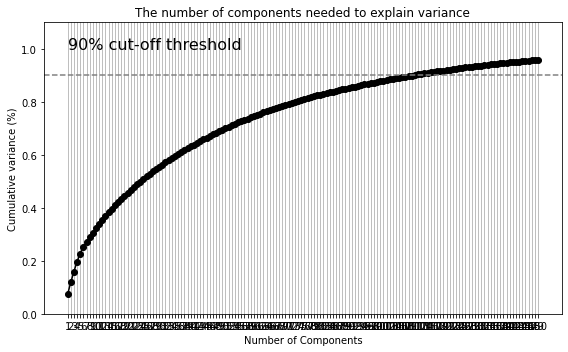

In [147]:
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(X)

pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 151, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi[:151], y[:150], marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 151, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.90, color='grey', linestyle='--')
plt.text(1.1, 1, '90% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)

In [148]:
pca = PCA(n_components=130)
pca = pca.fit(X)
X_pca = pca.transform(X)
components = pca.components_.T
X = np.array(X)
X_pca_test = np.matmul(X, components)
X_pca_test = np.around(X_pca_test, decimals=3)
X_pca = np.around(X_pca, decimals=3)
np.array_equal(X_pca,X_pca_test)

True

## Part 3: Clustering

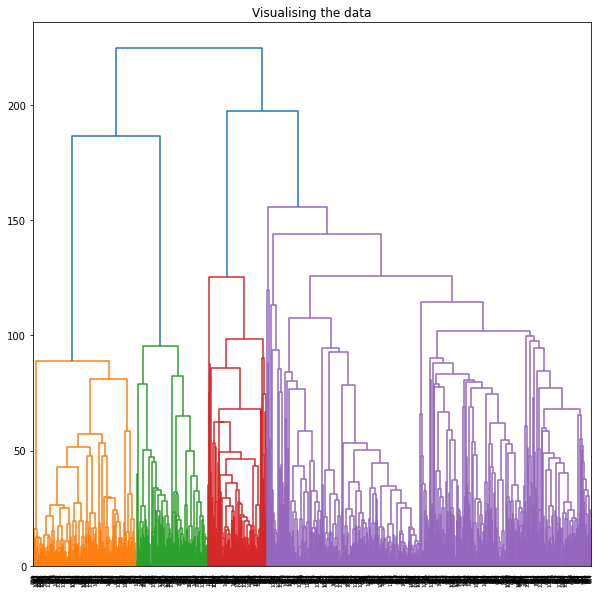

In [149]:
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
plt.figure(figsize =(10, 10))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X, method ='ward')))

In [150]:
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

n_clusters = 5

In [151]:
from sklearn.cluster import KMeans
#Kmeans without PCA
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
prediction = kmeans.predict(X)
print(f'Silhouette Score(n=5): {silhouette_score(X, prediction)}')

prediction = pd.DataFrame(prediction)
data_labelled = prediction.join(df)
data_labelled = data_labelled.iloc[:, [0, 1, 10]]
data_labelled.columns = ['Cluster','RulesetId', 'Name']
data_labelled['Cluster'].value_counts()
# filename = str(n_clusters) +'_K_MEANS_filtered' +'.csv'
# pd.DataFrame(data_labelled).to_csv(filename)

Silhouette Score(n=4): 0.05315111719183119


4    322
2    302
3    211
0    148
1    121
Name: Cluster, dtype: int64

In [152]:
import math
n, _ = data_labelled.shape
clusters = data_labelled['Cluster'].value_counts().sort_index()
m = n/70
c = 0
g = 0
subset = pd.DataFrame(data=None, columns=data_labelled.columns)
for i in clusters:
  num_games = math.ceil(i / m)
  g += num_games
  sub_df = data_labelled.loc[data_labelled['Cluster'] == c]
  sub_df = sub_df.sample(n=num_games)
  subset = pd.concat([subset, sub_df])
  c+=1
# filename = 'subset_' + str(n_clusters) +'_K_MEANS_filtered_random' +'.csv'
# pd.DataFrame(subset).to_csv(filename)
# subset['Cluster'].value_counts()

In [153]:
#Kmeans with pca
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=0).fit(X_pca)
prediction_pca_k = kmeans_pca.predict(X_pca)

print(f'Silhouette Score(n=2): {silhouette_score(X_pca, prediction_pca_k)}')


prediction_pca_k = pd.DataFrame(prediction_pca_k)
data_labelled_pca = prediction_pca_k.join(df)
data_labelled_pca = data_labelled_pca.iloc[:, [0, 1, 2, 3]]
data_labelled_pca.columns = ['Cluster','RulesetId', 'Name', 'Distance']
data_labelled_pca['Cluster'].value_counts()
# filename = str(n_clusters) +'take' +'.csv'
# pd.DataFrame(data_labelled_pca).to_csv(filename)

Silhouette Score(n=2): 0.04954773357747607


0    682
4    211
1    145
3     37
2     29
Name: Cluster, dtype: int64

In [154]:
data_labelled_pca

,Cluster,RulesetId,Name,Distance
0,0,918,Do Guti,Do Guti
1,0,595,Symbol S.2,Symbol S.2
2,0,1986,Elea,Elea
3,3,417,Salta,Salta
4,0,1734,Double-Move Situ,Double-Move Situ
...,...,...,...,...
1099,0,185,Shiva,Shiva
1100,0,952,Driesticken,Driesticken
1101,0,463,Minishogi,Minishogi
1102,0,154,Tuknanavuhpi,Tuknanavuhpi


In [155]:
import math
n, _ = data_labelled_pca.shape
clusters = data_labelled_pca['Cluster'].value_counts().sort_index()
m = n/70
c = 0
g = 0
subset = pd.DataFrame(data=None, columns=data_labelled_pca.columns)
for i in clusters:
  num_games = math.ceil(i / m)
  g += num_games
  sub_df = data_labelled_pca.loc[data_labelled_pca['Cluster'] == c]
  sub_df = sub_df.sample(n=num_games)
  subset = pd.concat([subset, sub_df])
  c+=1
# filename = 'subset_' + str(n_clusters) +'_K_MEANS_PCA_filtered_random' +'.csv'
# pd.DataFrame(subset).to_csv(filename)
# subset['Cluster'].value_counts()

### Other clustering

### Birch

In [156]:
# birch clustering

#Birch without pca
model = Birch(threshold=0.01, n_clusters=n_clusters)
model.fit(X)
yhat = model.predict(X)
print(f'Silhouette Score(n=4): {silhouette_score(X, yhat)}')


yhat = pd.DataFrame(yhat)
data_labelled = yhat.join(df)
data_labelled = data_labelled.iloc[:, [0, 1, 3]]
data_labelled.columns = ['Cluster','RulesetId', 'Name']
data_labelled['Cluster'].value_counts()

Silhouette Score(n=4): 0.0386098714485049


0    633
3    205
4    142
2    117
1      7
Name: Cluster, dtype: int64

In [157]:
n, _ = data_labelled.shape
clusters = data_labelled['Cluster'].value_counts().sort_index()
m = n/70
c = 0
g = 0
subset = pd.DataFrame(data=None, columns=data_labelled.columns)
for i in clusters:
  num_games = math.ceil(i / m)
  g += num_games
  sub_df = data_labelled.loc[data_labelled['Cluster'] == c]
  sub_df = sub_df.sample(n=num_games)
  subset = pd.concat([subset, sub_df])
  c+=1

#filename = 'subset_' + str(n_clusters) + '_Birch' + '.csv'
#pd.DataFrame(subset).to_csv(filename)

In [158]:
#Birch with pca
model = Birch(threshold=0.01, n_clusters=n_clusters)
model.fit(X_pca)
yhat = model.predict(X_pca)
print(f'Silhouette Score(n=2): {silhouette_score(X_pca, yhat)}')


yhat = pd.DataFrame(yhat)
data_labelled = yhat.join(df)
data_labelled = data_labelled.iloc[:, [0, 1, 3]]
data_labelled.columns = ['Cluster','RulesetId', 'Name']
data_labelled['Cluster'].value_counts()

n, _ = data_labelled.shape
clusters = data_labelled['Cluster'].value_counts().sort_index()
m = n/70
c = 0
g = 0
subset = pd.DataFrame(data=None, columns=data_labelled.columns)
for i in clusters:
  num_games = math.ceil(i / m)
  g += num_games
  sub_df = data_labelled.loc[data_labelled['Cluster'] == c]
  sub_df = sub_df.sample(n=num_games)
  subset = pd.concat([subset, sub_df])
  c+=1

#filename = 'subset_' + str(n_clusters) + '_Birch_PCA' + '.csv'
#pd.DataFrame(subset).to_csv(filename)

Silhouette Score(n=2): 0.05689475428917746


Score data

In [159]:
scores_4 = [0.033, 0.029]
scores_5 = [0.056, 0.037]

cols = ['K-Means', 'Birch']
index = ['4', '5']

scores = pd.DataFrame(columns = cols, index =index, data = [scores_4, scores_5])
#filename = 'silhouette_score_' +'.csv'
#pd.DataFrame(scores).to_csv(filename)

In [160]:
scores_5 = [0.063, 0.015, 0.061, 0.074]
scores_7 = [0.075, 0.065, 0.073, 0.084]

cols = ['K-Means', 'K-Means-PCA', 'Birch', 'Birch-PCA']
index = ['5', '7']

scores = pd.DataFrame(columns = cols, index =index, data = [scores_5, scores_7])
#filename = 'silhouette_score_og' +'.csv'
#pd.DataFrame(scores).to_csv(filename)

## Create subset

Get the centroids of each clusters and get the X closest to add to the subset

In [161]:
def get_distance(centroid, instance):
  distance = np.linalg.norm(centroid-instance)

  return distance

In [162]:
# Method to know how many games from each cluster to get

def number(df, threshold):
  result = math.ceil(df.shape[0]/threshold)

  return result

In [163]:
# Method to sort the df then select X we want for the subset
def subset(df, threshold):

  df = df.sort_values('Distance')

  elements = number(df, threshold)
  
  df1 = df.iloc[:elements-1]
  df1 = df1.append(df.tail(1))

  return df1


In [164]:
# Create the subset
def create_subset(one, two, three, four, five, threshold):
  one = subset(one, threshold)
  two = subset(two, threshold)
  three = subset(three, threshold)
  four = subset(four, threshold)
  five = subset(five, threshold)

  #Merge dfs
  frames = [one, two, three, four, five]

  result = pd.concat(frames)
  return result

In [165]:
# TO CALL TO CREATE A SUBSET:

def final(kmeans, df, x):
  dist = []
  centroids = kmeans.cluster_centers_

  for i in range(df.shape[0]):

    cluster = df['Cluster'][i]
    centroid = centroids[cluster]
    temp = x[i]
    dist.append(get_distance(centroid, temp))

  df['Distance'] = dist

  zero = df.loc[df['Cluster'] == 0]
  one = df.loc[df['Cluster'] == 1]
  two = df.loc[df['Cluster'] == 2]
  three = df.loc[df['Cluster'] == 3]
  four = df.loc[df['Cluster'] == 4]

  subset_final = create_subset(zero, one, two, three, four, 13)

  return subset_final

In [166]:
kmeans_no_pca = final(kmeans, data_labelled, X)
# filename = 'subset_' + str(n_clusters) +'_K_MEANS_filtered' +'.csv'
# kmeans_no_pca.to_csv(filename)

kmean_pca = final(kmeans_pca, data_labelled_pca, X_pca)
# filename = 'subset_' + str(n_clusters) +'_K_MEANS_PCA_filtered' +'.csv'
# kmean_pca.to_csv(filename)

In [167]:
data_labelled_pca['Cluster'].value_counts()

0    682
4    211
1    145
3     37
2     29
Name: Cluster, dtype: int64

In [168]:
data.to_csv('data_.csv')